### Import python library

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow.keras.backend as K 

from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
# import plotly.graph_objects as go

from math import sqrt

### 1. Read data: augment_24group_1620.csv필요

In [3]:
PCT_lstm_train_X = pd.read_csv("lstmPCT/PCT_lstm_final_train_X.csv")
PCT_lstm_train_y = pd.read_csv("lstmPCT/PCT_lstm_final_train_y.csv")

PCT_lstm_test_X = pd.read_csv("lstmPCT/PCT_lstm_final_test_X.csv")
PCT_lstm_test_y = pd.read_csv("lstmPCT/PCT_lstm_final_test_y.csv")

In [4]:
team = list(PCT_lstm_train_X.T_ID.unique())
year = list(PCT_lstm_train_y.YEAR.unique())

In [5]:
team, year

(['LG', 'HH', 'NC', 'HT', 'SK', 'KT', 'WO', 'LT', 'SS', 'OB'],
 [2016, 2017, 2018, 2019])

#### 4) input shape로 변경 (row, timestep=2, feature)

ex) 
timestep = 2

* X_train_v 구성예시: [[1 ~ 24경기 데이터, 25 ~ 48경기 데이터], [49 ~ 72경기 데이터, 73 ~ 96경기 데이터] ]  
X_train_v.shape >> (2,2*x)             # x: 각 24group에 대한 변수 개수
* y_train_v 구성예시: 97 ~ 120 경기 승률

=> reshape

* X_train_v.shape >> (2,2,x)  # row, timestep, feature

### 2. 모델 구성(LSTM)
- optimizer: RMSprop -> lr(learning rate) 조절
- LSTM: 모델이 계속 동일한 결과값이 나올 때, input 뉴런 개수를 늘려야 한다는 글을 읽고 계속 input 노드 개수를 바꿔주면서 모델 생성중
- loss: MSE

- early_stop: patience를 크게하면 과적합 되는 경우가 있어서 최대한 작게 설정해둠
- batch_size: 모델이 계속 동일한 결과값이 나올 때, 데이터가 적어 batch size를 줄여보라는 글을 읽고 1로 설정해둠

In [6]:
PCT_lstm_test_X

,T_ID,YEAR,shift_AVG_1,shift_BB_9_1,shift_CB_WHIP_RT_1,shift_DER_1,shift_ERA_1,shift_FIP_1,shift_GPA_1,shift_HR_9_1,...,shift_vs_SLG_2,shift_vs_TA_2,shift_vs_WHIP_2,shift_vs_oAVG_2,shift_vs_oISO_2,shift_vs_oOBP_2,shift_vs_oOPS_2,shift_vs_oSLG_2,shift_vs_wOBA_2,shift_wOBA_2
0,HH,2016,0.293083,3.839062,2.363817,0.651719,6.412500,1.645312,0.268321,1.307813,...,0.388166,0.741325,1.759259,0.314943,0.162069,0.379620,0.856632,0.477011,0.377625,0.436762
1,HT,2016,0.293286,4.394366,1.823909,0.641481,5.957746,1.211268,0.281933,0.929577,...,0.436385,0.813990,1.713622,0.316032,0.167243,0.371227,0.854503,0.483276,0.398699,0.432195
2,KT,2016,0.281437,3.493610,1.797718,0.639098,5.736422,1.207668,0.253729,1.078275,...,0.494062,0.907873,1.364929,0.262958,0.098609,0.325792,0.687359,0.361568,0.461189,0.345682
3,LG,2016,0.294471,3.685714,2.053119,0.666667,5.400000,1.052381,0.262976,0.771429,...,0.451843,0.864434,1.643519,0.300585,0.147368,0.360772,0.808726,0.447953,0.421377,0.409351
4,LT,2016,0.256250,3.471429,1.694264,0.665172,5.314286,1.695238,0.253391,1.285714,...,0.479388,0.900322,1.560372,0.292771,0.154217,0.347826,0.794814,0.446988,0.445309,0.402832
5,NC,2016,0.294611,4.069074,2.190766,0.693846,5.086342,1.521193,0.283405,1.102041,...,0.409915,0.709003,1.597774,0.287654,0.188889,0.354123,0.830666,0.476543,0.383845,0.434575
6,OB,2016,0.297974,3.442396,1.754090,0.687688,4.271889,1.502304,0.296301,1.161290,...,0.426270,0.782820,1.516381,0.287952,0.154217,0.343949,0.786118,0.442169,0.397175,0.392536
7,SK,2016,0.286055,3.948113,1.880222,0.667656,5.646226,1.363208,0.264029,0.933962,...,0.468235,0.859425,1.587692,0.310185,0.196759,0.354274,0.861218,0.506944,0.422476,0.422803
8,SS,2016,0.329186,3.685714,1.867744,0.672965,6.214286,2.314286,0.294895,1.542857,...,0.459172,0.813694,1.561271,0.283688,0.150118,0.352459,0.786265,0.433806,0.404514,0.406971
9,WO,2016,0.297398,2.859813,1.634289,0.684054,4.584112,1.285047,0.282030,1.093458,...,0.462670,0.803459,1.844340,0.334940,0.179518,0.393756,0.908214,0.514458,0.409059,0.459327


In [7]:
model_dict = dict()
hist_dict = dict()

ccol = ['y','y_pred',"shift_PCT_1","shift_PCT_2",'rms','rms0.5']
test_pred_df = pd.DataFrame([],columns = ['T_ID','YEAR','y','y_pred',"shift_PCT_1","shift_PCT_2",'rms','rms0.5'])
test_pred_df[["T_ID","YEAR"]] = PCT_lstm_test_X[["T_ID","YEAR"]]

idx = 0

tmp1 = PCT_lstm_train_X.drop(["T_ID","YEAR"],axis = 1)
tmp2 = PCT_lstm_train_y.drop(["T_ID","YEAR"],axis=1)
tmp3 = PCT_lstm_test_X.drop(["T_ID",'YEAR'],axis=1)
tmp4 = PCT_lstm_test_y.drop(["T_ID",'YEAR'],axis=1)

X_train = tmp1
y_train = tmp2
X_test = tmp3
y_test = tmp4

X_train_v = X_train.values
y_train_v = y_train.values

X_test_v = X_test.values
y_test_v = y_test.values

X_train_t = X_train_v.reshape(X_train_v.shape[0], 2,X_train_v.shape[1]//2)
X_test_t = X_test_v.reshape(X_test_v.shape[0], 2,X_test_v.shape[1]//2)


In [8]:

## model
K.clear_session() 

model = Sequential()
optimizer = Adam(lr=0.01)
#         optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)

model.add(LSTM(100,input_shape = (2,X_train_v.shape[1]//2))) # (timestep, feature)
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

model.summary()

#         hist1 = model.fit(X_train_t, y_train_v, epochs=100, batch_size=1, verbose=1)

early_stop = EarlyStopping(monitor='loss', mode = 'min',patience=2, verbose=1)

hist1 = model.fit(X_train_t, y_train_v, epochs=100,
          batch_size=2, verbose=1, callbacks=[early_stop])
##

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               63200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 63,301
Trainable params: 63,301
Non-trainable params: 0
_________________________________________________________________
Train on 1960 samples
Epoch 1/100
1960/1960 [==============================] - 5s 2ms/sample - loss: 0.0293 - mae: 0.1124
Epoch 2/100
1960/1960 [==============================] - 3s 1ms/sample - loss: 0.0168 - mae: 0.1042
Epoch 3/100
1960/1960 [==============================] - 3s 2ms/sample - loss: 0.0173 - mae: 0.1043
Epoch 4/100
1960/1960 [==============================] - 3s 1ms/sample - loss: 0.0162 - mae: 0.1026
Epoch 5/100
1960/1960 [==============================] - 3s 2ms/sample - loss: 0.0168 - mae:

In [11]:
X_test_t[0].shape

(2, 57)

In [12]:
y_test_v[0]

array([0.5])

In [13]:
for tt in range(len(X_test_t)):
    ttmp = X_test_t[tt].reshape(1,X_test_t[tt].shape[0],X_test_t[tt].shape[1])
    y_pred = model.predict(ttmp)
    rms = sqrt(mean_squared_error(y_test_v[tt], y_pred))
    rms05 = sqrt(mean_squared_error(y_test_v[tt], [0.5]))

    test_pred_df.loc[idx,ccol] = [y_test_v[tt].reshape(-1)[0],y_pred.reshape(-1)[0],
                              X_test.loc[X_test.index[tt],["shift_PCT_1"]][0],
                              X_test.loc[X_test.index[tt],["shift_PCT_2"]][0], rms,rms05]
 

test_pred_df[['y','y_pred',"shift_PCT_1","shift_PCT_2",'rms','rms0.5']] = test_pred_df[['y','y_pred',"shift_PCT_1","shift_PCT_2",'rms','rms0.5']].astype(float)

In [14]:
test_pred_df

,T_ID,YEAR,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
0,HH,2016,0.666667,0.564801,0.565217,0.708333,0.101866,0.166667
1,HT,2016,NaN,NaN,NaN,NaN,NaN,NaN
2,KT,2016,NaN,NaN,NaN,NaN,NaN,NaN
3,LG,2016,NaN,NaN,NaN,NaN,NaN,NaN
4,LT,2016,NaN,NaN,NaN,NaN,NaN,NaN
5,NC,2016,NaN,NaN,NaN,NaN,NaN,NaN
6,OB,2016,NaN,NaN,NaN,NaN,NaN,NaN
7,SK,2016,NaN,NaN,NaN,NaN,NaN,NaN
8,SS,2016,NaN,NaN,NaN,NaN,NaN,NaN
9,WO,2016,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
test_pred_df.groupby(["YEAR"]).mean()

,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
YEAR,,,,,,
2016,0.492391,0.510814,0.504167,0.508514,0.070072,0.075725
2017,0.498370,0.488735,0.491848,0.521937,0.105351,0.076630
2018,0.507971,0.511459,0.500362,0.497480,0.042255,0.071377
2019,0.505072,0.520403,0.508152,0.495290,0.121830,0.105072


In [41]:
test_pred_df

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
0,2016,LG,0.608696,0.650341,0.583333,0.458333,0.041645,0.108696
1,2017,LG,0.434783,0.505163,0.304348,0.652174,0.070380,0.065217
2,2018,LG,0.416667,0.464049,0.291667,0.478261,0.047382,0.083333
3,2019,LG,0.541667,0.497537,0.541667,0.500000,0.044129,0.041667
4,2016,HH,0.500000,0.465625,0.500000,0.608696,0.034375,0.000000
5,2017,HH,0.434783,0.472319,0.541667,0.333333,0.037537,0.065217
6,2018,HH,0.500000,0.424813,0.416667,0.583333,0.075187,0.000000
7,2019,HH,0.583333,0.435061,0.375000,0.250000,0.148272,0.083333
8,2016,NC,0.565217,0.460554,0.500000,0.541667,0.104664,0.065217
9,2017,NC,0.500000,0.455474,0.458333,0.541667,0.044526,0.000000


In [33]:
test_pred_df.groupby(["T_ID"]).mean()

,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
T_ID,,,,,,
HH,0.504529,0.532457,0.458333,0.443841,0.089852,0.037138
HT,0.500000,0.493976,0.504982,0.539402,0.019504,0.020833
KT,0.431159,0.376189,0.401268,0.434824,0.084700,0.089674
LG,0.500453,0.489523,0.430254,0.522192,0.044770,0.074728
LT,0.510417,0.482492,0.493659,0.435771,0.161231,0.156250
NC,0.511775,0.556893,0.505435,0.494565,0.051286,0.053442
OB,0.631793,0.594275,0.674366,0.580616,0.042592,0.131793
SK,0.479167,0.515187,0.510417,0.562500,0.144313,0.083333
SS,0.457428,0.458000,0.443388,0.450593,0.054178,0.053442


In [34]:
test_pred_df["diff"] = test_pred_df["rms"] - test_pred_df["rms0.5"]
test_pred_df

,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5,diff
0,LG,0.608696,0.562782,0.583333,0.458333,0.045914,0.108696,-0.062782
1,LG,0.434783,0.475488,0.304348,0.652174,0.040705,0.065217,-0.024512
2,LG,0.416667,0.443642,0.291667,0.478261,0.026975,0.083333,-0.056358
3,LG,0.541667,0.476182,0.541667,0.500000,0.065484,0.041667,0.023818
4,HH,0.500000,0.547024,0.500000,0.608696,0.047024,0.000000,0.047024
5,HH,0.434783,0.623317,0.541667,0.333333,0.188535,0.065217,0.123317
6,HH,0.500000,0.494210,0.416667,0.583333,0.005790,0.000000,0.005790
7,HH,0.583333,0.465275,0.375000,0.250000,0.118058,0.083333,0.034725
8,NC,0.565217,0.565169,0.500000,0.541667,0.000049,0.065217,-0.065169
9,NC,0.500000,0.558253,0.458333,0.541667,0.058253,0.000000,0.058253


In [37]:
test_pred_df.groupby(["YEAR"]).mean()

,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
YEAR,,,,,,
2016,0.492391,0.494809,0.504167,0.508514,0.072740,0.075725
2017,0.498370,0.488187,0.491848,0.521937,0.105915,0.076630
2018,0.507971,0.517371,0.500362,0.497480,0.061284,0.071377
2019,0.505072,0.509891,0.508152,0.495290,0.123604,0.105072


In [38]:
from sklearn.metrics import r2_score
tmp = test_pred_df.copy()
# tmp['half']= 0.5
r2_y_predict = r2_score(tmp['y'], tmp['y_pred'])
r2_y_predict

-0.43951953874474237

#### +======================================+

In [40]:
 #100, lr = 0.01, patience 2 +++, rms ver, rms05 ver, Adam, batch2

test_pred_df

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
0,2016,LG,0.608696,0.522544,0.583333,0.458333,0.086151,0.108696
1,2016,HH,0.500000,0.510781,0.500000,0.608696,0.010781,0.000000
2,2016,NC,0.565217,0.543209,0.500000,0.541667,0.022008,0.065217
3,2016,HT,0.458333,0.577802,0.500000,0.583333,0.119468,0.041667
4,2016,SK,0.458333,0.522475,0.458333,0.458333,0.064141,0.041667
5,2016,KT,0.291667,0.328833,0.333333,0.375000,0.037166,0.208333
6,2016,WO,0.375000,0.600633,0.625000,0.666667,0.225633,0.125000
7,2016,LT,0.500000,0.470777,0.375000,0.500000,0.029223,0.000000
8,2016,SS,0.500000,0.440369,0.500000,0.434783,0.059631,0.000000
9,2016,OB,0.666667,0.537850,0.666667,0.458333,0.128817,0.166667


In [41]:
test_pred_df.groupby(["YEAR"]).mean()

,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
YEAR,,,,,,
2016,0.492391,0.505527,0.504167,0.508514,0.078302,0.075725
2017,0.498370,0.477456,0.491848,0.521937,0.111321,0.076630
2018,0.507971,0.501531,0.500362,0.497480,0.062153,0.071377
2019,0.505072,0.511206,0.508152,0.495290,0.117584,0.105072


In [88]:
test_pred_df #300, lr = 0.01

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.468182,0.583333,0.458333
1,2016,HH,0.5,0.567216,0.5,0.608696
2,2016,NC,0.565217,0.492161,0.5,0.541667


In [75]:
test_pred_df #300, lr = 0.001

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.423421,0.583333,0.458333
1,2016,HH,0.5,0.479113,0.5,0.608696


In [86]:
test_pred_df #300, lr = 0.0005

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.490298,0.583333,0.458333
1,2016,HH,0.5,0.672277,0.5,0.608696
2,2016,NC,0.565217,0.653289,0.5,0.541667


In [96]:
test_pred_df #100, lr = 0.1

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,2.45143,0.583333,0.458333
1,2016,HH,0.5,-2.15025,0.5,0.608696
2,2016,NC,0.565217,-1.5099,0.5,0.541667


In [104]:
test_pred_df #100, lr = 0.01, patience 3

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.46766,0.583333,0.458333
1,2016,HH,0.5,0.554741,0.5,0.608696
2,2016,NC,0.565217,0.540454,0.5,0.541667
3,2016,HT,0.458333,0.586706,0.5,0.583333
4,2016,SK,0.458333,0.492073,0.458333,0.458333
5,2016,KT,0.291667,0.450251,0.333333,0.375
6,2016,WO,0.375,0.629395,0.625,0.666667
7,2016,LT,0.5,0.417594,0.375,0.5
8,2016,SS,0.5,0.488712,0.5,0.434783
9,2016,OB,0.666667,0.553688,0.666667,0.458333


In [102]:
test_pred_df #100, lr = 0.01, patience 1

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.477605,0.583333,0.458333
1,2016,HH,0.5,0.509489,0.5,0.608696
2,2016,NC,0.565217,0.519098,0.5,0.541667
3,2016,HT,0.458333,0.585744,0.5,0.583333
4,2016,SK,0.458333,0.462029,0.458333,0.458333
5,2016,KT,0.291667,0.333392,0.333333,0.375
6,2016,WO,0.375,0.543434,0.625,0.666667
7,2016,LT,0.5,0.377705,0.375,0.5
8,2016,SS,0.5,0.400355,0.5,0.434783
9,2016,OB,0.666667,0.539122,0.666667,0.458333


In [7]:
 #100, lr = 0.01, patience 2 +++, rms ver, rms05 ver, Adam

test_pred_df

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
0,2016,LG,0.608696,0.506664,0.583333,0.458333,0.102032,0.108696
1,2016,HH,0.5,0.518261,0.5,0.608696,0.0182612,0
2,2016,NC,0.565217,0.520184,0.5,0.541667,0.0450339,0.0652174
3,2016,HT,0.458333,0.562111,0.5,0.583333,0.103777,0.0416667
4,2016,SK,0.458333,0.487501,0.458333,0.458333,0.0291681,0.0416667
5,2016,KT,0.291667,0.372884,0.333333,0.375,0.0812176,0.208333
6,2016,WO,0.375,0.578908,0.625,0.666667,0.203908,0.125
7,2016,LT,0.5,0.431082,0.375,0.5,0.0689185,0
8,2016,SS,0.5,0.4259,0.5,0.434783,0.0740999,0
9,2016,OB,0.666667,0.496237,0.666667,0.458333,0.170429,0.166667


In [139]:
 #100, lr = 0.01, patience 2 +++, rms ver, rms05 ver
# model_copy = model_dict.copy()
# hist_copy = hist_dict.copy()
# tmp_df = test_pred_df.copy()
tmp_df

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2,rms,rms0.5
0,2016,LG,0.608696,0.612487,0.583333,0.458333,0.00379184,0.108696
1,2016,HH,0.5,0.434664,0.5,0.608696,0.0653357,0
2,2016,NC,0.565217,0.529742,0.5,0.541667,0.0354756,0.0652174
3,2016,HT,0.458333,0.542623,0.5,0.583333,0.0842892,0.0416667
4,2016,SK,0.458333,0.442084,0.458333,0.458333,0.0162496,0.0416667
5,2016,KT,0.291667,0.350306,0.333333,0.375,0.0586392,0.208333
6,2016,WO,0.375,0.586355,0.625,0.666667,0.211355,0.125
7,2016,LT,0.5,0.475668,0.375,0.5,0.0243322,0
8,2016,SS,0.5,0.475334,0.5,0.434783,0.024666,0
9,2016,OB,0.666667,0.537623,0.666667,0.458333,0.129044,0.166667


In [132]:
test_pred_df #100, lr = 0.01, patience 2 +++, rms ver

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2,rms
0,2016,LG,0.608696,0.287378,0.583333,0.458333,0.321318
1,2016,HH,0.5,0.582811,0.5,0.608696,0.0828107
2,2016,NC,0.565217,0.587976,0.5,0.541667,0.0227588
3,2016,HT,0.458333,0.542857,0.5,0.583333,0.0845234
4,2016,SK,0.458333,0.453548,0.458333,0.458333,0.00478577
5,2016,KT,0.291667,0.332341,0.333333,0.375,0.0406745
6,2016,WO,0.375,0.544543,0.625,0.666667,0.169543
7,2016,LT,0.5,0.41319,0.375,0.5,0.0868104
8,2016,SS,0.5,0.434083,0.5,0.434783,0.0659173
9,2016,OB,0.666667,0.746169,0.666667,0.458333,0.0795019


In [106]:
test_pred_df #100, lr = 0.01, patience 2 ++

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.435018,0.583333,0.458333
1,2016,HH,0.5,0.534284,0.5,0.608696
2,2016,NC,0.565217,0.626261,0.5,0.541667
3,2016,HT,0.458333,0.544398,0.5,0.583333
4,2016,SK,0.458333,0.556326,0.458333,0.458333
5,2016,KT,0.291667,0.371262,0.333333,0.375
6,2016,WO,0.375,0.670688,0.625,0.666667
7,2016,LT,0.5,0.443552,0.375,0.5
8,2016,SS,0.5,0.401195,0.5,0.434783
9,2016,OB,0.666667,0.483709,0.666667,0.458333


In [100]:
test_pred_df #100, lr = 0.01, patience 2

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.288105,0.583333,0.458333
1,2016,HH,0.5,0.504434,0.5,0.608696
2,2016,NC,0.565217,0.539863,0.5,0.541667
3,2016,HT,0.458333,0.548684,0.5,0.583333
4,2016,SK,0.458333,0.418596,0.458333,0.458333
5,2016,KT,0.291667,0.35347,0.333333,0.375
6,2016,WO,0.375,0.663121,0.625,0.666667
7,2016,LT,0.5,0.495439,0.375,0.5
8,2016,SS,0.5,0.383013,0.5,0.434783
9,2016,OB,0.666667,0.541724,0.666667,0.458333


In [90]:
test_pred_df #100, lr = 0.01

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.467328,0.583333,0.458333
1,2016,HH,0.5,0.527652,0.5,0.608696
2,2016,NC,0.565217,0.52047,0.5,0.541667
3,2016,HT,0.458333,0.429098,0.5,0.583333
4,2016,SK,0.458333,0.4829,0.458333,0.458333


In [94]:
test_pred_df #100, lr = 0.001

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.542802,0.583333,0.458333
1,2016,HH,0.5,0.545997,0.5,0.608696
2,2016,NC,0.565217,0.567216,0.5,0.541667
3,2016,HT,0.458333,0.577572,0.5,0.583333
4,2016,SK,0.458333,0.604854,0.458333,0.458333
5,2016,KT,0.291667,0.42159,0.333333,0.375
6,2016,WO,0.375,0.598227,0.625,0.666667
7,2016,LT,0.5,0.386472,0.375,0.5
8,2016,SS,0.5,0.329622,0.5,0.434783


In [73]:
test_pred_df #100, lr = 0.001

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.478348,0.583333,0.458333
1,2016,HH,0.5,0.529292,0.5,0.608696


In [92]:
test_pred_df #100, lr=0.0005

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.494715,0.583333,0.458333
1,2016,HH,0.5,0.630847,0.5,0.608696
2,2016,NC,0.565217,0.489612,0.5,0.541667
3,2016,HT,0.458333,0.593727,0.5,0.583333
4,2016,SK,0.458333,0.523688,0.458333,0.458333
5,2016,KT,0.291667,0.243116,0.333333,0.375
6,2016,WO,0.375,0.637864,0.625,0.666667
7,2016,LT,0.5,0.400517,0.375,0.5
8,2016,SS,0.5,0.314818,0.5,0.434783


In [98]:
test_pred_df #200, lr = 0.01

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.545502,0.583333,0.458333
1,2016,HH,0.5,0.636396,0.5,0.608696
2,2016,NC,0.565217,0.607057,0.5,0.541667
3,2016,HT,0.458333,0.607852,0.5,0.583333
4,2016,SK,0.458333,0.419407,0.458333,0.458333
5,2016,KT,0.291667,0.42172,0.333333,0.375
6,2016,WO,0.375,0.52766,0.625,0.666667
7,2016,LT,0.5,0.30456,0.375,0.5
8,2016,SS,0.5,0.501613,0.5,0.434783
9,2016,OB,0.666667,0.591436,0.666667,0.458333


In [79]:
test_pred_df #200, lr = 0.001

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.392572,0.583333,0.458333
1,2016,HH,0.5,0.548009,0.5,0.608696


In [81]:
test_pred_df #200, lr=0.0005

,YEAR,T_ID,y,y_pred,shift_PCT_1,shift_PCT_2
0,2016,LG,0.608696,0.513151,0.583333,0.458333
1,2016,HH,0.5,0.573316,0.5,0.608696
2,2016,NC,0.565217,0.635897,0.5,0.541667
3,2016,HT,0.458333,0.470724,0.5,0.583333


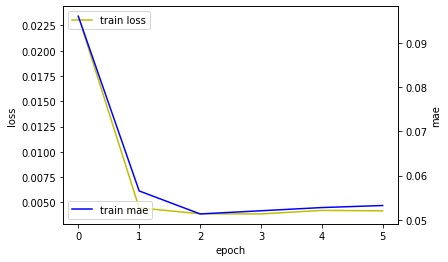

In [76]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist1.history['loss'], 'y', label='train loss')

acc_ax.plot(hist1.history['mae'], 'b', label='train mae')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mae')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()